In [5]:
%matplotlib inline
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import tensorflow as tf
import numpy as np
import librosa
from utils.strechableNumpyArray import StrechableNumpyArray
import matplotlib.pyplot as plt
from architecture.parameters.lstmParameters import LstmParameters
from architecture.simpleLSTMArchitecture import SimpleLSTMArchitecture
from system.lstmPreAndPostProcessor import LSTMPreAndPostProcessor
from system.lstmSystem import LSTMSystem
import IPython
import functools
from tensorflow.contrib.signal.python.ops import window_ops


In [216]:
import importlib
import system
importlib.reload(system.lstmSystem)
import architecture
importlib.reload(architecture.contextEncoderLSTMArchitecture)
from architecture.contextEncoderLSTMArchitecture import ContextEncoderLSTMArchitecture
import system
importlib.reload(system.preAndPostProcessor)
from system.preAndPostProcessor import PreAndPostProcessor

from system.lstmSystem import LSTMSystem

In [56]:
tf.reset_default_graph()

from architecture.contextEncoderLSTMArchitecture import ContextEncoderLSTMArchitecture
from architecture.parameters.lstmContextInpaintingParameters import LstmContextInpaintingParameters
from system.lstmSystem import LSTMSystem
import os

from system.preAndPostProcessor import PreAndPostProcessor

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

sessionsName = "nsynth_lotsoweights_nopadded_trainTotalLoss_"

params = LstmContextInpaintingParameters(lstmSize=512, batchSize=64, signalLength=5120, inputChannels=2,
										 gapLength=1024, fftWindowLength=512, fftHopSize=128)

contextArchitecture = ContextEncoderLSTMArchitecture(params)

aPreProcessor = PreAndPostProcessor(params)

aContextEncoderSystem = LSTMSystem(contextArchitecture, aPreProcessor, params, sessionsName)


(64, 16, 257)
(64, 16, 257, 2)
(64, 13, 257)


In [4]:
sr = 16000
start_in_seconds = 0.1
side_length = 2048
gap_length = 1024
starting_sample_left_side = int(sr*start_in_seconds)
ending_sample_left_side = starting_sample_left_side + side_length
starting_sample_right_side = ending_sample_left_side + gap_length
ending_sample_right_side = starting_sample_right_side + side_length

best_step = 962830
batch_size = 64

In [3]:
pathToDatasetFolder = "../LSTMsOnSpectrograms/nsynth-test/audio"
audios = StrechableNumpyArray()
i = 0
total = 0
file_names = []
for file_name in os.listdir(pathToDatasetFolder):
    audio, sr = librosa.load(pathToDatasetFolder + '/' + file_name, sr=None)

    if np.sum(np.absolute(audio[5120:5120*2])) < 5120*1e-3: 
        print(file_name, "doesn't meet the minimum amplitude requirement")
        continue

    file_names.append(file_name)
    audios.append(audio)
    i+=1

    if i > 500:
        i -= 500
        total += 500
        print("500 plus!", total)
        break
#         if total >= 0 and i >= 8:
#             break
print("there were: ", total+i)

audios = audios.finalize()
audios = np.reshape(audios, (total+i, len(audio)))
print(audios.shape)

bass_electronic_018-022-100.wav doesn't meet the minimum amplitude requirement
bass_electronic_018-023-025.wav doesn't meet the minimum amplitude requirement
bass_electronic_025-022-050.wav doesn't meet the minimum amplitude requirement
bass_electronic_027-022-050.wav doesn't meet the minimum amplitude requirement
500 plus! 500
there were:  501
(501, 64000)


In [206]:
original_signals = audios[:, starting_sample_left_side:ending_sample_right_side]
original_gaps = audios[:, ending_sample_left_side:starting_sample_right_side]

In [57]:
generatedSpecs = aContextEncoderSystem.reconstruct(original_signals, model_num=962830)

INFO:tensorflow:Restoring parameters from utils/saved_models/nsynth_lotsoweights_nopadded_trainTotalLoss_/model-nsynth_lotsoweights_nopadded_trainTotalLoss_962830.ckpt
Model restored.


In [63]:
generatedSpecs[0].shape
# len(original_signals)

(448, 11, 257)

Text(0.5,1,'reconstructed')

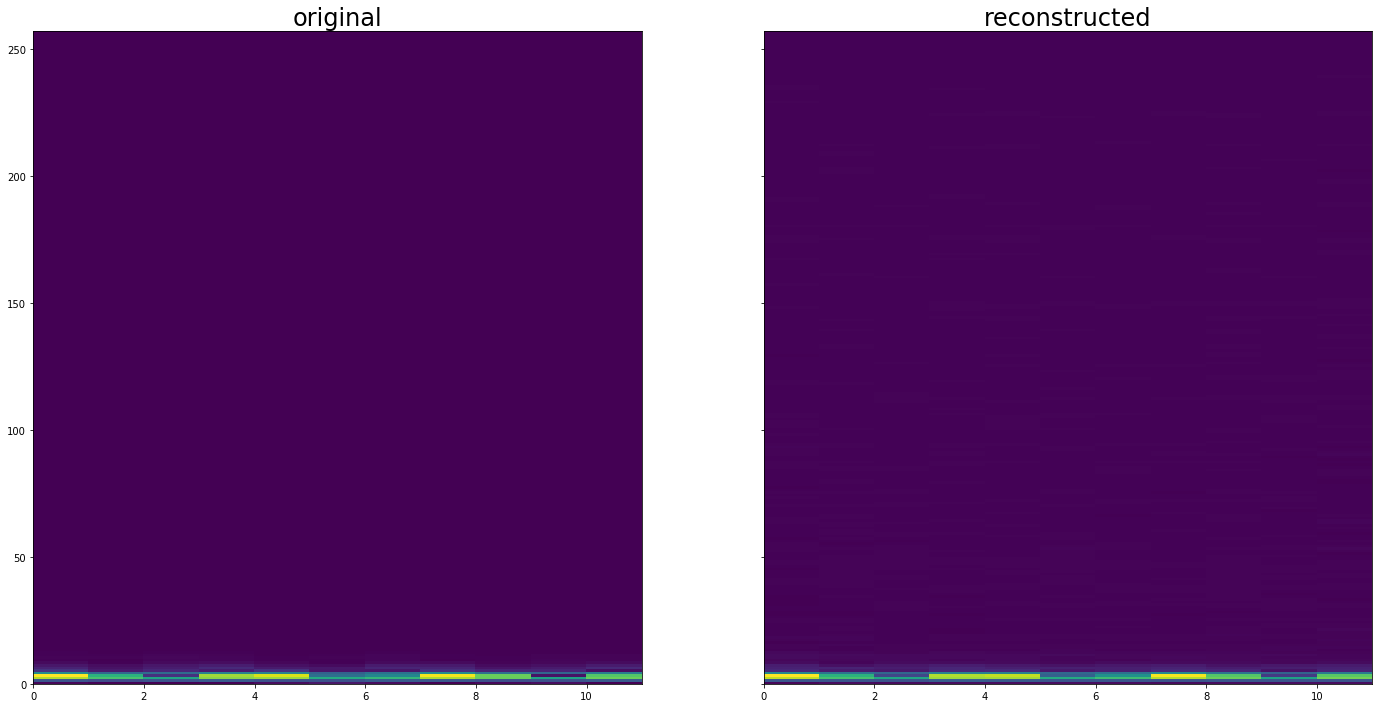

In [101]:
testOn = 50

f, axarr = plt.subplots(1, 2, sharey='row', figsize=(24, 12))

#scaleeee

axarr[0].pcolormesh(generatedSpecs[1][testOn].transpose())
axarr[0].set_title('original', size=24)
axarr[1].pcolormesh(generatedSpecs[0][testOn].transpose())
axarr[1].set_title('reconstructed', size=24)


In [161]:
import copy
def griffinLim(realSignals, passes, params):
    absolute_values = copy.copy(realSignals)
    window_fn = functools.partial(window_ops.hann_window, periodic=True)
    inverse_window = tf.contrib.signal.inverse_stft_window_fn(params.fftHopSize(),
                                           forward_window_fn=window_fn)
    stft_to_invert = tf.placeholder(tf.complex64, shape=realSignals.shape, name='stft_to_invert')
    tf_inverse_stft = tf.contrib.signal.inverse_stft(stfts=stft_to_invert, frame_length=params.fftWindowLength(), 
                                                              frame_step=params.fftHopSize(), window_fn=inverse_window)
    tf_forward_stft = tf.contrib.signal.stft(signals=tf_inverse_stft, frame_length=params.fftWindowLength(), 
                                          frame_step=params.fftHopSize(), window_fn=window_fn)
    with tf.Session() as sess:
        for i in range(passes):
            realSignals = absolute_values + 1.0j*np.imag(realSignals)
            feed_dict = {stft_to_invert: realSignals}
            realSignals = sess.run(tf_forward_stft, feed_dict=feed_dict)
        feed_dict = {stft_to_invert: realSignals}
        return sess.run(tf_inverse_stft, feed_dict=feed_dict)


In [168]:
timeSignals = griffinLim(generatedSpecs[1], 300, params)
originalTimeSignals = griffinLim(generatedSpecs[0], 300, params)

In [169]:
timeSignals.shape

(448, 1792)

In [78]:
IPython.display.Audio(data=timeSignals[10], rate=16000)

In [207]:
reconstructedSignals = np.concatenate([audios[:len(timeSignals), :ending_sample_left_side], -1*timeSignals[:, params.padding():-params.padding()], audios[:len(timeSignals), starting_sample_right_side:]], axis=1)
rec_original_signals = np.concatenate([audios[:len(timeSignals), :ending_sample_left_side], -1*originalTimeSignals[:len(timeSignals), params.padding():-params.padding()], audios[:len(timeSignals), starting_sample_right_side:]], axis=1)

In [146]:
original_gaps.shape

(501, 1024)

In [158]:
original_signals.shape

(448, 64000)

In [184]:
IPython.display.Audio(data=reconstructedSignals[50], rate=16000)

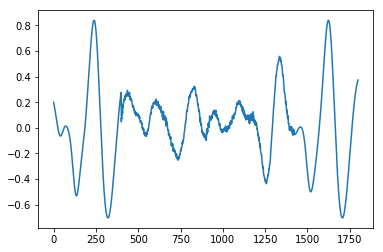

In [215]:
plt.plot(rec_original_signals[50,ending_sample_left_side-400:ending_sample_left_side+1400])

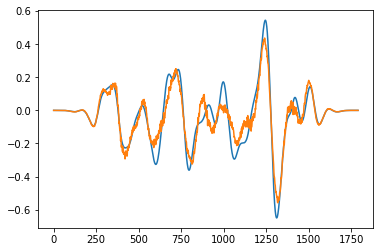

In [213]:
plt.plot(timeSignals[50])
plt.plot(originalTimeSignals[50])

In [208]:
stftOp = aPreProcessor.stftForGapOf(original_signals)

with tf.Session() as sess:
    stft = sess.run(stftOp)
    

In [209]:
stft.shape

(501, 11, 257)

In [188]:
generatedSpecs[0].shape

(448, 11, 257)

Text(0.5,1,'reconstructed')

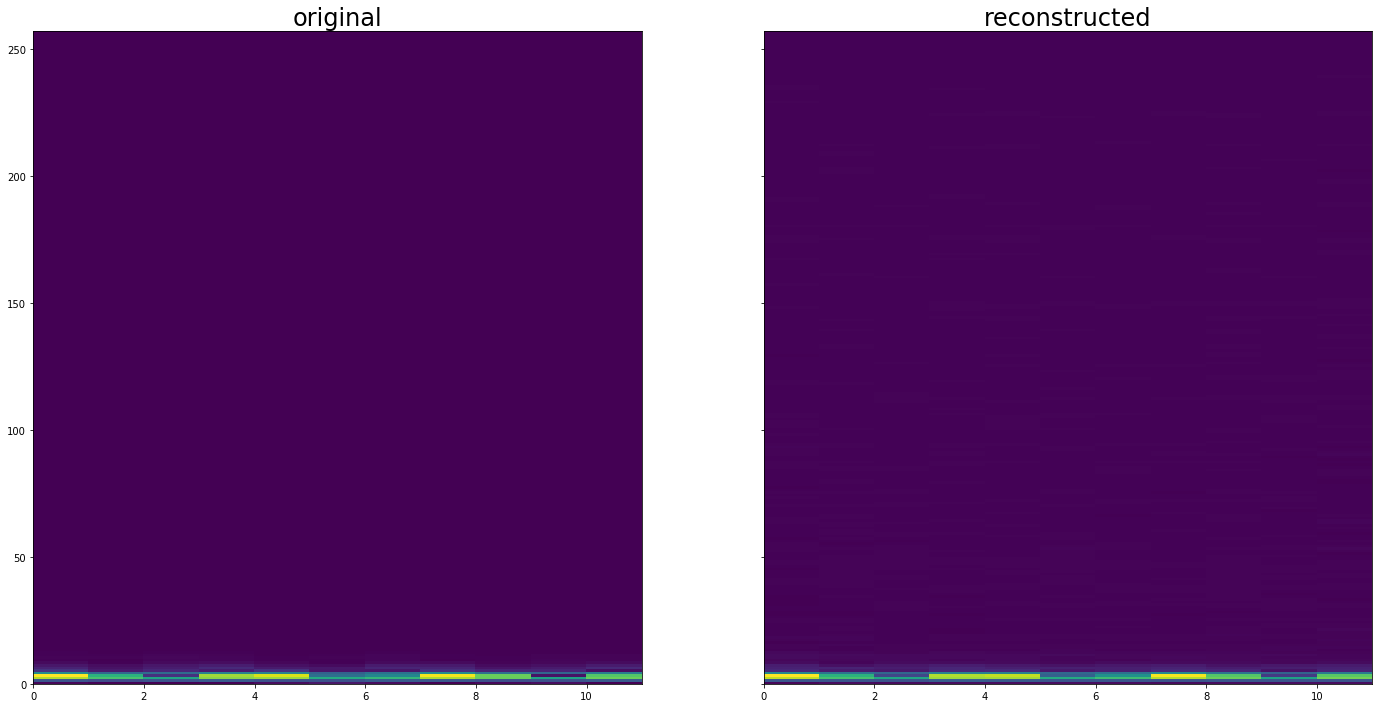

In [210]:
testOn = 50

f, axarr = plt.subplots(1, 2, sharey='row', figsize=(24, 12))

#scaleeee

axarr[0].pcolormesh(stft[testOn].transpose())
axarr[0].set_title('original', size=24)
axarr[1].pcolormesh(generatedSpecs[0][testOn].transpose())
axarr[1].set_title('reconstructed', size=24)

In [202]:
generatedSpecs[0][10]==generatedSpecs[1][10]

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [212]:
def _pavlovs_SNR(y_orig, y_inp, onAxis=(1,)):
    norm_y_orig = _squaredEuclideanNorm(y_orig, onAxis)
    norm_y_orig_minus_y_inp = _squaredEuclideanNorm(y_orig - y_inp, onAxis)
    return 10 * np.log10(norm_y_orig / norm_y_orig_minus_y_inp)

def _squaredEuclideanNorm(vector, onAxis=(1,)):
    squared = np.square(vector)
    summed = np.sum(squared, axis=onAxis)
    return summed

print(np.mean(_pavlovs_SNR(generatedSpecs[0], generatedSpecs[1], onAxis=(1, 2))))

print(np.mean(_pavlovs_SNR(generatedSpecs[0], stft[:448], onAxis=(1, 2))))

print(np.mean(_pavlovs_SNR(stft[:448], generatedSpecs[1], onAxis=(1, 2))))

21.128754
21.128754
inf


c:\users\andres\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
